<h1 style="text-align: center;">Representation and Inference of Graphical Models</h1>

In [197]:
import re
import time
import pprint
import difflib
import graphviz
import copy
import matplotlib.pyplot as plt

from itertools import product, combinations
from collections import defaultdict, OrderedDict as odict
from tabulate import tabulate

## Helper Functions

In [198]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen. If the `ext` field is presented, it will be printed as an additional column
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        
        # NEW CODE
        # if the 'ext' key is present in the factor, we apppend the ext dictionary converted to a list of items
        if 'ext' in f:
            k.append(list(f['ext'][key].items()))
        
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')

    print(tabulate(table,headers=dom,tablefmt='orgtbl'))

In [199]:
def join(f1, f2, outcomeSpace):
    """
    argument
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable

    Returns a new factor with a join of f1 and f2. This version tests of the existance of `ext` field and merge them in the resulting factor
    """
    if not f1:
        return f2

    if not f2:
        return f1

    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))

    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()

    # Here is where the magic happens. The product iterator will generate all combinations of varible values
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):

        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = tuple((entryDict[var] for var in f1['dom']))
        f2_entry = tuple((entryDict[var] for var in f2['dom']))

        # Insert your code here
        # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry
        p1 = f1['table'][f1_entry]
        # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry
        p2 = f2['table'][f2_entry]

        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))

    return {'dom': tuple(common_vars), 'table': odict(table)}


In [200]:
def marginalize(f, var, outcomeSpace):
    """
    argument
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable

    Returns a new factor f' with dom(f') = dom(f) - {var}
    """

    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    # Remove var from the list new_dom by calling the method remove(). 1 line
    new_dom.remove(var)
    # Create an empty list for table. We will fill in table from scratch. 1 line
    table = list()
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)

            # Calculate the probability of factor f for entriesList. 1 line
            p = f['table'][tuple(entriesList)]
            # Sum over all values of var by accumulating the sum in s. 1 line
            s = s + p

        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}


In [201]:
def normalize(f):
    """
    argument
    `f`, factor to be normalized.

    Returns a new factor f' as a copy of f with entries that sum up to 1
    """
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        if sum == 0:
            table.append((k, 0))
        else:
            table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}


## Class for Bayes Network
### Network Representation:
   - child_graph: Adjacency list. Dictionary of Nodes as keys and it's children as its values.
   - prob_tables: Probability distribution table
   
   We follow the hugin file format (.net) which is a text file with two main sections.
 
   ----
   The first one specifies the nodes.
 
       node HISTORY
       {
           states = ( "TRUE" "FALSE" );
       }

       node LVFAILURE
       {
           states = ( "TRUE" "FALSE" );
       }

   The second part specifies the probability tables, and has the following format:

       potential ( HISTORY | LVFAILURE )
       {
           data = ((0.9 0.1)(0.01 0.99)) ;
       }

   ----

### Member Functions:
- load_network(File)
 > Loads a hugin (.net) file and parses it to obtain the respective Bayes net.
- insert_node(Node, Domain)
 > Inserts given node into the graph.
- remove_node(Node)
 > Removes the specified node from the graph.
- connect_nodes(Node1, Node2)
 > Connects child node (Node2) to parent node (Node1).
- disconnect_nodes()
 > Disconnects child node (node2) from parent node (Node1).
- prob_node(Node, Prob)
 > Sets probability of the node.
- save_network(File)
 > Saves the Bayes net into a hugin (.net) File.
    

In [202]:
class Bayes_Network():
    def __init__(self, File):
        self.node_pattern = re.compile(
            "\W+node\s(\w*)\W+states\W+\((.*)\)\W+\}")
        self.prob_pattern = re.compile(
            "\W+potential\W+\((.*)\)\W+data\W+\((.*)\)")
        self.outcomeSpace = {}
        self.child_graph = defaultdict(list)
        self.prob_tables = self.load_network(File)

    def load_network(self, File):
        prob_table = defaultdict(lambda: defaultdict(odict))
        with open(File, 'r') as file:
            x = file.read()
            m = self.node_pattern.findall(x)
            for tup in m:
                dom = tup[1].replace('"', " ")
                self.outcomeSpace[tup[0]] = dom.split()

            prob = self.prob_pattern.findall(x)

            for tup in prob:
                dom = tup[0].replace("|", " ")
                dom = dom.split()

                prob = tup[1].replace("(", " ")
                prob = prob.replace(")", " ")
                prob = prob.split()

                prob_table[dom[0]]['dom'] = tuple(dom)

                l = [self.outcomeSpace[i] for i in dom]
                x = list(product(*l))
                for i in range(len(x)):
                    prob_table[dom[0]]['table'][x[i]] = float(prob[i])

                self.child_graph[dom[0]] = []
                for i in range(1, len(dom)):
                    self.child_graph[dom[i]].append(dom[0])

        return prob_table

    def insert_node(self, Node, Domain):
        self.outcomeSpace[Node] = Domain
        self.child_graph[Node] = []

        table = odict()
        p = 1  # /len(Domain)
        for x in Domain:
            table[(x, )] = p

        self.prob_tables[Node] = {'dom': (Node,),
                                  'table': table}

        return

    def remove_node(self, Node):
        for v in self.child_graph[Node]:
            self.disconnect_nodes(Node, v)

        for v in self.prob_tables[Node]['dom'][1:]:
            self.disconnect_nodes(v, Node)

        del self.outcomeSpace[Node]
        del self.prob_tables[Node]
        del self.child_graph[Node]

        return

    def connect_nodes(self, Node1, Node2):
        # Node1 is parent
        # Node2 is child

        self.child_graph[Node1].append(Node2)
        # Join tables
        prob_table = self.prob_tables[Node1]
        temp_list = list(self.prob_tables[Node1]['dom'])
        temp_list.remove(Node1)
        for var in temp_list:
            prob_table = marginalize(prob_table, var, self.outcomeSpace)
        prob_table = normalize(prob_table)
        self.prob_tables[Node2] = join(
            self.prob_tables[Node2], prob_table, self.outcomeSpace)

        return

    def disconnect_nodes(self, Node1, Node2):
        # Node1 is parent
        # Node2 is child

        self.child_graph[Node1].remove(Node2)
        self.prob_tables[Node2] = marginalize(Node2, Node1, self.outcomeSpace)

        return

    def prob_node(self, Node, Prob):
        # Prob should be dictionary with key as the tuple of value
        # and value as the probability.
        for k, v in Prob.items():
            self.prob_tables[Node]['table'][k] = v

        return

    def save_network(self, filename):
        with open(filename, 'w') as file:
            file.write("net\n{\n}\n")
            for node, domain in self.outcomeSpace.items():
                file.write("node %s\n" % node)
                dom = ''
                for i in domain:
                    dom += ' \"' + i + '\"'
                file.write("{\n  states = (%s);\n}\n" % dom)

            for node, v in self.prob_tables.items():
                s = " ".join(v['dom'][1:])
                if s:
                    node = node + ' | ' + s
                file.write("potential ( %s )\n{\n" % node)
                prob = ' '.join([str(prob) for prob in v['table'].values()])
                file.write("  data = ( %s ) ;\n}\n" % prob)

        return


### Test Representation
The following code snippet demonstrate the representation of the Bayes net class.


In [203]:
def test_representation():
    filename = "./asia.net"
    b_net = Bayes_Network(filename)

    output_file = "./out_asia.net"
    b_net.save_network(output_file)

test_representation()

#### Contents of asia.net:

    net 
    { 
    }
    node asia 
    {
      states = ( "yes" "no");
    }
    ...
    node dysp 
    {
      states = ( "yes" "no" );
    }
    
    
    potential ( asia ) 
    {
      data = ( 0.01 0.99 );
    }
    ...
    potential ( dysp | bronc either ) 
    {
      data = (((0.9 0.1)(0.8 0.2))((0.7 0.3)(0.1 0.9))) ;
    }

#### Contents of output file out_asia.net:

    net 
    { 
    }
    node asia 
    {
      states = ( "yes" "no");
    }
    ...
    node dysp 
    {
      states = ( "yes" "no" );
    }
    
 The probabilities are in the order of all True (TTT..) to all false (FFF..)
    
    potential ( asia ) 
    {
      data = ( 0.01 0.99 );
    }
    ...
    potential ( dysp | bronc either ) 
    {
      data = ( 0.9 0.1 0.8 0.2 0.7 0.3 0.1 0.9 ) ;
    }

### Test Functionalities of Bayes Net Class
The following code snippet demonstrate the functionalities of the Bayes net class.

In [204]:
def test_functionalities():
    filename = "./test1.net"
    b_net = Bayes_Network(filename)

    output_file = "./out_test.net"

    Node1 = 'Xray'
    b_net.insert_node(Node1, ['positive', 'negative'])
    
#     print('New Prob Table1:')
#     pprint.pprint(b_net.prob_tables)
    
    b_net.connect_nodes('Cancer', 'Xray')

#     print('New Prob Table2:')
#     pprint.pprint(b_net.prob_tables)
#     b_net.save_network(output_file)

#     b_net.remove_node(Node1)
    b_net.save_network(output_file)

test_functionalities()

## Pruning and Pre-Processing Techniques For Inference

1. Network pruning techniques based on query structure. This technique is composed of edge and node pruning.
2. Min-fill heuristic for variable elimination, using min-degree heuristics to break ties.

In [205]:
class Pruning(Bayes_Network):
    def __init__(self, filename):
        super().__init__(filename)
        self.induced_graph = defaultdict(list)
        self.factors = self.factorisation()

    def factorisation(self):
        return [i['dom'] for i in self.prob_tables.values() if len(i['dom']) > 1]

    def moralisation(self):
        for node, v in self.prob_tables.items():
            parents = sorted(v['dom'])

            if len(parents) > 1:
                for i in range(len(parents)):
                    for j in range(i+1, len(parents)):
                        self.induced_graph[parents[i]].append(parents[j])
                        self.induced_graph[parents[j]].append(parents[i])

        self.induced_graph = {k: sorted(v)
                              for k, v in self.induced_graph.items()}

        return

    def prune_edge(self, Pruned_network, Node):
        del Pruned_network[Node]
        return

    def prune_nodes(self, Pruned_network, Node, R):
        for v in self.prob_tables[Node]['dom'][1:]:
            Pruned_network[v].remove(Node)
            if not Pruned_network[v] and v not in R:
                self.prune_nodes(v, R)

        return

    def pruning(self, Query, **Evidence):
        pruned_network = self.child_graph.copy()
        retained_nodes = [Query] + list(Evidence.keys())

        for node, children in self.child_graph.items():
            if not children and node not in Query and node not in Evidence:
                self.prune_nodes(pruned_network, node, retained_nodes)

        for node in Evidence:
            self.prune_edge(pruned_network, node)

        return pruned_network

    def node_degree(self):
        node_degree = defaultdict(int)
        for n, nodes in self.induced_graph.items():
            node_degree[n] += len(nodes)
            for node in nodes:
                node_degree[node] += 1

        return node_degree

    def min_fill(self):
        node_min_fill = defaultdict(list)
        node_degree = self.node_degree()

        for n, nodes in self.induced_graph.items():
            node_min_fill[n].append(sum([1 for i in range(len(nodes))
                                         for j in range(i+1, len(nodes))
                                         if not nodes[j] in self.induced_graph[nodes[i]]]))
            node_min_fill[n].append(node_degree[n])

        return sorted(node_min_fill, key=node_min_fill.get)


### Test Pruning
The following code snippet demonstrate the Pruning technique to speed up the inference. 

In [206]:
def test_pruning():
    filename = "./asia.net"
    b_net = Pruning(filename)
    b_net.moralisation()
    b_net.pruning("tub", bronc="yes", either="yes")
    print(b_net.min_fill())

test_pruning()

['asia', 'xray', 'dysp', 'smoke', 'tub', 'lung', 'bronc', 'either']


## Exact Inference
Implemented the Jointree Algorithm using the Shenoy-Shaffer architecture. The steps followed:
- Convert an elimination order into a join tree
- Join Tree Transformations: Add/Merge/Remove Clusters
- Answer query based on the Join Tree.
- Set evidence

In [207]:
class Exact_Inference(Bayes_Network):
    def __init__(self, File, Elimination_order):
        super().__init__(File)
        self.factors = self.factorisation()
        self.clusters = defaultdict(lambda: defaultdict())
        self.join_tree = self.make_jointree(Elimination_order)

    def factorisation(self):
        return {i['dom']: {'dom': i['dom'],
                           'table': i['table']} for i in self.prob_tables.values() if len(i['dom']) > 1}

    def make_jointree(self, Elimination_order):
        jointree = defaultdict(lambda: defaultdict())

        clusters = self.add_clusters(Elimination_order)
        clusters = self.merge_clusters(clusters)

        union_set = set()
        for cluster in reversed(clusters):
            if not union_set:
                jointree[tuple(cluster)] = defaultdict()

            else:
                intersection_set = set(cluster) & union_set

                for k in list(jointree.keys()):
                    if intersection_set.issubset(k):
                        jointree[k][tuple(cluster)] = defaultdict()
                        jointree[tuple(cluster)][k] = defaultdict()

            union_set |= set(c for c in cluster)

        return jointree

    def set_evidence(self, Evidence):
        newOutcomeSpace = self.outcomeSpace.copy()
        for var, e in Evidence.items():
            newOutcomeSpace[var] = (e,)
        return newOutcomeSpace

    def merge_clusters(self, clusters):
        seen_list = []
        for cluster in clusters:
            seen_list.append(set(cluster))
            for item in seen_list[:-1]:
                if cluster < item:
                    seen_list.remove(item)
                    seen_list.remove(set(cluster))
                    seen_list.append(item)
                    break
                if item <= cluster:
                    seen_list.remove(item)
                    break

        return seen_list

    def add_clusters(self, Elimination_order):
        clusters = []
        eliminated_nodes = []
        temp_list = list(self.factors.keys())
        for node in Elimination_order:
            lis = set(factor for factors in temp_list
                      for factor in factors
                      if node in factors)

            cluster = lis - set(eliminated_nodes)
            clusters.append(cluster)
            
            for factors, v in self.factors.items():
                if set(factors) <= set(cluster):
                    if not self.clusters[tuple(cluster)]:
                        self.clusters[tuple(cluster)] = v
                    else:
                        self.clusters[tuple(cluster)] = join(self.clusters[tuple(cluster)], v, self.outcomeSpace)

            flag = 0
            for i in range(len(self.child_graph[node])):
                for j in range(i+1, len(self.child_graph[node])):
                    for factors in temp_list:
                        if self.child_graph[node][i] in factors and self.child_graph[node][j] in factors:
                            flag += 1
                    if not flag:
                        temp_list.append(
                            (self.child_graph[node][i], self.child_graph[node][j]))

            eliminated_nodes.append(node)

        return clusters

    def remove_cluster(self):
        return

    def in_list(self, A, B):
        if not A or not B:
            return True
        for a in A:
            if a in B:
                return True

        return False

    def compute_message(self, cluster, outcomeSpace):
        message = self.clusters[cluster]
        for k, v in self.join_tree[cluster].items():
            if v:
                message = join(message, v, outcomeSpace)

        return message

    def send_message(self, cluster1, cluster2, outcomeSpace):

        message = self.clusters[cluster1]
        domain = set(cluster1) - set(cluster2)
        for k, v in self.join_tree[cluster1].items():
            if v:
                message = join(message, v, outcomeSpace)
                for var in list(set(message['dom']) - domain):
                    message = marginalize(message, var, outcomeSpace)

        self.join_tree[cluster2][cluster1] = message

        return

    def generate_pass_order(self, current, queried, message_order, seen_list):
        for cluster in self.join_tree[current]:
            if cluster not in seen_list and self.in_list(queried, cluster):
                seen_list.append(cluster)
                message_order.append(cluster)
                self.generate_pass_order(
                    cluster, queried, message_order, seen_list)

        return

    def ans_query(self, Query, **Evidence):

        leaf_clusters = [k for k, v in self.join_tree.items()
                         if len(v) == 1]

        outcomeSpace = self.set_evidence(Evidence)

        evidence = list(Evidence.keys())
        flag = 0
        root = None
        for cluster in self.join_tree.keys():
            if flag:
                break
            if Query in cluster and self.in_list(evidence, cluster):
                flag = 1
                root = cluster
            elif Query in cluster:
                root = cluster

        message_order = []
        if flag:
            queried = [Query] + evidence
            self.generate_pass_order(root, queried, message_order, [])
        else:
            queried = list(self.outcomeSpace.keys())
            self.generate_pass_order(root, queried, message_order, [])

        length = len(message_order)
        for i in range(length-2):
            self.send_message(
                message_order[length-i-1], message_order[length-i-2], outcomeSpace)

        output = self.clusters[root]
        for var in output['dom']:
            if var != Query:
                output = marginalize(output, var, outcomeSpace)

        return normalize(output)


### Test Exact Inference
The following code snippet demonstrates the method of exact inference of the given query.

In [187]:
def test_exact_inference():
    filename = "./munin.net"
    b_net = Pruning(filename)
    b_net.moralisation()
    x = Exact_Inference(filename, b_net.min_fill())
    printFactor(x.ans_query('R_LNLW_MED_SEV', DIFFN_SEV="MOD"))
    return


test_exact_inference()

| R_LNLW_MED_SEV   |     Pr |
|------------------+--------|
| NO               | 0.2    |
| MILD             | 0.2095 |
| MOD              | 0.1905 |
| SEV              | 0.2    |
| TOTAL            | 0.2    |


In [188]:
# def test_exact_inference():
#     filename = "./asia.net"
#     b_net = Pruning(filename)
#     b_net.moralisation()
#     x = Exact_Inference(filename, b_net.min_fill())
#     print(x.ans_query('lung', asia="yes", tub="no"))
#     return


# def test_exact_inference():
#     filename = "./asia.net"
#     b_net = Pruning(filename)
#     b_net.moralisation()
#     x = Exact_Inference(filename, b_net.min_fill())
#     print(x.ans_query('lung', asia="yes", tub="no"))
#     # print(x.ans_query('L_OTHER_ISCH_DIFSLOW', L_SUR_ALLCV_CA='M_S52'))#, asia="yes", tub="no"))
#     return


# test_exact_inference()

## Approximate inference
###  Iterative Joingraph Propagation (IJGP)
* Create Bethe cluster graph and use it as join graph
* Answer query based on join graph clusters
* Set evidence

In [208]:
class Approx_Inference(Bayes_Network):
    def __init__(self, File):
        super().__init__(File)
        self.factors = self.factorisation()
        self.clusters = defaultdict(lambda: defaultdict())
        self.bethe_graph = self.create_Bethe_graph()

    def factorisation(self):
        return {i['dom']: {'dom': i['dom'],
                           'table': i['table']} for i in self.prob_tables.values() if len(i['dom']) > 1}

    def create_Bethe_graph(self):
        cluster_graph = defaultdict(lambda: defaultdict())
        clusters = []
        singleton_clusters = []

        for node in self.outcomeSpace.keys():
            singleton_clusters.append((node,))

        for factors in self.factors:
            for c in singleton_clusters:
                if c[0] in factors:
                    cluster_graph[factors][c] = defaultdict()
                    cluster_graph[c][factors] = defaultdict()
            clusters.append(factors)

        for k, v in self.factors.items():
            self.clusters[k] = v

        for cluster in singleton_clusters:
            self.clusters[cluster] = self.prob_tables[cluster[0]].copy()
            for var in self.prob_tables[cluster[0]]['dom']:
                if var not in cluster:
                    self.clusters[cluster] = marginalize(
                        self.clusters[cluster], var, self.outcomeSpace)

        return cluster_graph

    def add_clusters(self, clusters):

        return

    def set_evidence(self, Evidence):
        newOutcomeSpace = self.outcomeSpace.copy()
        for var, e in Evidence.items():
            newOutcomeSpace[var] = (e,)
        return newOutcomeSpace

    def in_list(self, A, B):
        if not A or not B:
            return True
        for a in A:
            if a in B:
                return True

        return False

    def cluster_message(self, root, outcomeSpace, visited_clusters):
        visited_clusters.append(root)
        prob_table = self.clusters[root]
        for cluster in self.bethe_graph[root].keys():
            if cluster not in visited_clusters:
                if self.clusters[cluster]['table']:
                    prob_table = join(
                        prob_table, self.clusters[cluster], outcomeSpace)
                else:
                    self.clusters[cluster] = self.cluster_message(
                        cluster, outcomeSpace, visited_clusters)
                    prob_table = join(
                        prob_table, self.clusters[cluster], outcomeSpace)

        return prob_table

    def send_message(self, cluster1, cluster2, outcomeSpace):
        # From cluster 1 to cluster 2

        message = self.clusters[cluster1]
        domain = set(cluster1) - set(cluster2)
        for k, v in self.bethe_graph[cluster1].items():
            if v:
                message = join(message, v, outcomeSpace)
                for var in list(set(message['dom']) - domain):
                    message = marginalize(message, var, outcomeSpace)

        self.bethe_graph[cluster2][cluster1] = message

        return

    def generate_pass_order(self, current, queried, message_order, seen_list):
        for cluster in self.bethe_graph[current]:
            if cluster not in seen_list and self.in_list(queried, cluster):
                seen_list.append(cluster)
                message_order.append(cluster)
                self.generate_pass_order(
                    cluster, queried, message_order, seen_list)

        return

    def check_convergence(self, graph, message, delta, outcomeSpace):
        if not graph:
            return

        temp_val = graph.copy()
        if graph['dom'] != message['dom']:
            for var in list(set(graph['dom']) - set(message['dom'])):
                temp_val = marginalize(temp_val, var, outcomeSpace)

        for k, v in message['table'].items():
            if abs(temp_val['table'][k] - v) > delta:
                return False

        return True

    def update_message(self, graph, outcomeSpace, delta):
        for k, v in graph.items():
            for cluster, messages in v.items():
                message = self.clusters[k]

                for c, m in v.items():
                    if c != cluster and m:
                        message = join(message, m, outcomeSpace)
                        for var in message['dom']:
                            if var not in list(set(k) & set(cluster)):
                                message = marginalize(
                                    message, var, outcomeSpace)
                message = normalize(message)
                if self.check_convergence(graph[k][cluster], message, delta, outcomeSpace):
                    graph[k].pop(cluster, None)
                graph[k][cluster] = message
                self.bethe_graph[k][cluster] = message

        return

    def ans_query(self, delta, num_iters, Query, **Evidence):

        outcomeSpace = self.set_evidence(Evidence)
        temp_graph = self.bethe_graph.copy()

        iteration = 0
        while temp_graph and iteration < num_iters:
            self.update_message(temp_graph, outcomeSpace, delta)
            iteration += 1

        for cluster in self.bethe_graph.keys():
            if Query in cluster:
                root = cluster
                break

        evidence = list(Evidence.keys())
        flag = 0
        root = None
        for cluster in temp_graph.keys():
            if flag:
                break
            if Query in cluster and self.in_list(evidence, cluster):
                flag = 1
                root = cluster
            elif Query in cluster:
                root = cluster

        message_order = []
        if flag:
            queried = [Query] + evidence
            self.generate_pass_order(root, queried, message_order, [])
        else:
            queried = list(self.outcomeSpace.keys())
            self.generate_pass_order(root, queried, message_order, [])

        length = len(message_order)

        for i in range(length-2):
            self.send_message(
                message_order[length-i-1], message_order[length-i-2], outcomeSpace)

        output = self.clusters[root]
        for var in output['dom']:
            if var != Query:
                output = marginalize(output, var, outcomeSpace)

        return normalize(output)



### Test Approximate Inference using Iterative Join Graph Propagation Technique
The following code snippet demonstrates the method of approximate inference of the given query, following the Iterative Join Graph Propagation technique.

In [209]:
def test_approx_inference():
    filename = "./asia.net"
    b_net = Pruning(filename)
    b_net.moralisation()
    x = Approx_Inference(filename)
    printFactor(x.ans_query(0.01, 100, 'tub', asia="yes"))
    return


# def test_approx_inference():
#     filename = "./asia.net"
#     b_net = Pruning(filename)
#     b_net.moralisation()
#     x = Approx_Inference(filename)
#     x.ans_query('tub', asia="yes")
#     return

test_approx_inference()


| tub   |       Pr |
|-------+----------|
| yes   | 0.833333 |
| no    | 0.166667 |


## Benchmark


The inference techniques will be compared by analysing it over Bayes net of various sizes. We have chosen the following networks to draw a contrast:

1. Small Network       :  CANCER
2. Medium Network      :  CHILD
3. Large Network       :  HAILFINDER
4. Very Large Network  :  PATHFINDER
5. Massive Network     :  MUNIN (Full Network)

In [214]:
def plot_graph(graph, exact_result, approx_result):
    for k,v in exact_result['table'].items():
        graph.append((v, approx_result['table'][k]))
    return

graph = []

#### Small Network (< 20 Nodes)
* Bayes Net: CANCER
* Number of nodes:	 	5
* Number of arcs: 		4
* Number of parameters	: 	10
* Average Markov blanket size: 	2.00
* Average degree: 		1.60
* Maximum in-degree: 		2

Query:
> P(Xray | Cancer = 'True')

In [215]:
# Evaluate Query: CANCER
filename = "./cancer.net"

start_time = time.time()
print('Exact Inference:')
b_net = Pruning(filename)
b_net.moralisation()
exact_inf = Exact_Inference(filename, b_net.min_fill())
result1 = exact_inf.ans_query('Xray', Cancer="True")
# print("P(Xray | Cancer = 'True') =", result)
# pprint.pprint(result)
printFactor(result1)
print('Time:', time.time() - start_time)

print()

start_time = time.time()
print('Approximate Inference:')
b_net = Pruning(filename)
b_net.moralisation()
approx_inf = Approx_Inference(filename)
result2 = approx_inf.ans_query(0.01, 100, 'Xray', Cancer="True")
# print("P(Xray | Cancer = 'True') =", result)
# pprint.pprint(result)
printFactor(result2)
print('Time:', time.time() - start_time)

plot_graph(graph, result1, result2)

Exact Inference:
| Xray     |       Pr |
|----------+----------|
| positive | 0.818182 |
| negative | 0.181818 |
Time: 0.0029702186584472656

Approximate Inference:
| Xray     |       Pr |
|----------+----------|
| positive | 0.818182 |
| negative | 0.181818 |
Time: 0.05326724052429199


#### Medium Network (20 - 50 Nodes)
* Bayes Net: CHILD
* Number of nodes:	 	20
* Number of arcs: 		25
* Number of parameters	: 	230
* Average Markov blanket size: 	3.00
* Average degree: 		1.25
* Maximum in-degree: 		2

Query:
> P(LungFlow | Disease = 'Lung')

In [217]:
# Evaluate Query: CHILD
filename = "./child.net"

start_time = time.time()
print('Exact Inference:')
b_net = Pruning(filename)
b_net.moralisation()
exact_inf = Exact_Inference(filename, b_net.min_fill())
result1 = exact_inf.ans_query('LungFlow', Disease="Lung")
# print("P(LungFlow | Disease = 'Lung') =", result)
# pprint.pprint(result)
printFactor(result1)
print('Time:', time.time() - start_time)

print()

start_time = time.time()
print('Approximate Inference:')
b_net = Pruning(filename)
b_net.moralisation()
approx_inf = Approx_Inference(filename)
result2 = approx_inf.ans_query(0.01, 100, 'LungFlow', Disease="Lung")
# print("P(LungFlow | Disease = 'Lung') =", result)
# pprint.pprint(result)
printFactor(result2)
print('Time:', time.time() - start_time)

plot_graph(graph, result1, result2)

Exact Inference:
| LungFlow   |        Pr |
|------------+-----------|
| Normal     | 0.883686  |
| Low        | 0.0455467 |
| High       | 0.0707672 |
Time: 0.009591102600097656

Approximate Inference:
| LungFlow   |   Pr |
|------------+------|
| Normal     | 0.75 |
| Low        | 0.05 |
| High       | 0.2  |
Time: 0.6121549606323242


#### Large Network (50 - 100 Nodes)
* Bayes Net: HAILFINDER
* Number of nodes:	 	56
* Number of arcs: 		66
* Number of parameters	: 	2656
* Average Markov blanket size: 	3.54
* Average degree: 		2.36
* Maximum in-degree: 		4

Query:
> P(TempDis | Scenario = 'C')

In [218]:
# Evaluate Query: HAILFINDER
filename = "./hailfinder.net"

start_time = time.time()
print('Exact Inference:')
b_net = Pruning(filename)
b_net.moralisation()
exact_inf = Exact_Inference(filename, b_net.min_fill())
result1 = exact_inf.ans_query('TempDis', Scenario="C")
# print("P(TempDis | Scenario = 'C') =", result)
# pprint.pprint(result)
printFactor(result1)
print('Time:', time.time() - start_time)

print()

start_time = time.time()
print('Approximate Inference:')
b_net = Pruning(filename)
b_net.moralisation()
approx_inf = Approx_Inference(filename)
result2 = approx_inf.ans_query(0.01, 100, 'TempDis', Scenario="C")
# print("P(TempDis | Scenario = 'C') =", result)
# pprint.pprint(result)
printFactor(result2)
print('Time:', time.time() - start_time)

plot_graph(graph, result1, result2)

Exact Inference:
| TempDis     |        Pr |
|-------------+-----------|
| QStationary | 0.344828  |
| Moving      | 0.517241  |
| None        | 0.103448  |
| Other       | 0.0344828 |
Time: 0.07608699798583984

Approximate Inference:
| TempDis     |        Pr |
|-------------+-----------|
| QStationary | 0.344828  |
| Moving      | 0.517241  |
| None        | 0.103448  |
| Other       | 0.0344828 |
Time: 7.7873358726501465


#### Very Large Network (100 - 1000 Nodes)
* Bayes Net: PATHFINDER
* Number of nodes:	 	109
* Number of arcs: 		195
* Number of parameters	: 	72079
* Average Markov blanket size: 	3.81
* Average degree: 		3.57
* Maximum in-degree: 		5

Query:
> P(F108 | Fault = 'Infectious_mono')

In [219]:
# Evaluate Query: PATHFINDER
filename = "./pathfinder.net"

start_time = time.time()
print('Exact Inference:')
b_net = Pruning(filename)
b_net.moralisation()
exact_inf = Exact_Inference(filename, b_net.min_fill())
result1 = exact_inf.ans_query('F108', Fault="Infectious_mono")
# print("P(F108 | Fault = 'Infectious_mono') =", result)
# pprint.pprint(result)
printFactor(result1)
print('Time:', time.time() - start_time)

print()

start_time = time.time()
print('Approximate Inference:')
b_net = Pruning(filename)
b_net.moralisation()
approx_inf = Approx_Inference(filename)
result2 = approx_inf.ans_query(0.01, 100, 'F108', Fault="Infectious_mono")
# print("P(F108 | Fault = 'Infectious_mono') =", result)
# pprint.pprint(result)
printFactor(result2)
print('Time:', time.time() - start_time)

plot_graph(graph, result1, result2)

Exact Inference:
| F108    |   Pr |
|---------+------|
| Absent  |  0.5 |
| Present |  0.5 |
Time: 0.8416707515716553

Approximate Inference:
| F108    |   Pr |
|---------+------|
| Absent  |  0.5 |
| Present |  0.5 |
Time: 22.22428321838379


#### Massive Network (> 1000 Nodes)
* Bayes Net: MUNIN (Full Network)
* Number of nodes:	 	1041
* Number of arcs: 		1397
* Number of parameters	: 	80592
* Average Markov blanket size: 	3.54
* Average degree: 		2.68
* Maximum in-degree: 		3

Query:
> P(L_SUR_CV_CA | L_SUR_ALLCV_CA = 'M_S44')

In [221]:
# Evaluate Query: MUNIN (Full Network)
filename = "./munin.net"

start_time = time.time()
print('Exact Inference:')
b_net = Pruning(filename)
b_net.moralisation()
exact_inf = Exact_Inference(filename, b_net.min_fill())
result1 = exact_inf.ans_query('L_SUR_CV_CA', L_SUR_ALLCV_CA="M_S44")
# print("P(L_SUR_CV_CA | L_SUR_ALLCV_CA = 'M_S44') =", result)
# pprint.pprint(result)
printFactor(result1)
print('Time:', time.time() - start_time)

print()

start_time = time.time()
print('Approximate Inference:')
b_net = Pruning(filename)
b_net.moralisation()
approx_inf = Approx_Inference(filename)
result2 = approx_inf.ans_query(0.01, 100, 'L_SUR_CV_CA', L_SUR_ALLCV_CA="M_S44")
# print("P(L_SUR_CV_CA | L_SUR_ALLCV_CA = 'M_S44') =", result)
# pprint.pprint(result)
printFactor(result2)
print('Time:', time.time() - start_time)

plot_graph(graph, result1, result2)

Exact Inference:
| L_SUR_CV_CA   |          Pr |
|---------------+-------------|
| M_S00         | 0           |
| M_S04         | 0.0431844   |
| M_S08         | 0           |
| M_S12         | 0.36417     |
| M_S16         | 0           |
| M_S20         | 0.00342768  |
| M_S24         | 0.000685535 |
| M_S28         | 0           |
| M_S32         | 0.584533    |
| M_S36         | 0           |
| M_S40         | 0.00399936  |
| M_S44         | 0           |
| M_S48         | 0           |
| M_S52         | 0           |
| M_S56         | 0           |
| M_S60         | 0           |
| M_S_64        | 0           |
Time: 2.557680130004883

Approximate Inference:
| L_SUR_CV_CA   |          Pr |
|---------------+-------------|
| M_S00         | 0           |
| M_S04         | 0.0431844   |
| M_S08         | 0           |
| M_S12         | 0.36417     |
| M_S16         | 0           |
| M_S20         | 0.00342768  |
| M_S24         | 0.000685535 |
| M_S28         | 0           |
| M_S32

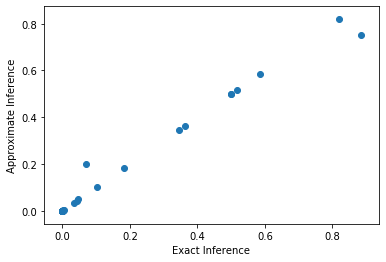

In [222]:
plt.xlabel("Exact Inference")
plt.ylabel("Approximate Inference")
plt.scatter(*zip(*graph))
plt.show()

## CONCLUSION

The above results show that the output from exact inference and approximate inference methods are very close to each other.

The other interesting thing to note is that exact inference runs considerably faster than approximate inference. Part of this reason can be due to the factors being pre-calculated for the exact inference method and iterations being done to find the same in approximate inference method. But given these factors, the two methods have the same complexity according to our implementation.